# **Import Library**

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas.api.types
import math
from scipy.stats import zscore

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier, XGBRegressor
from lifelines.utils import concordance_index
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from imblearn.under_sampling import RandomUnderSampler

# JCOPML Package
from jcopml.plot import plot_missing_value
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.tuning import random_search_params as rsp
from jcopml.feature_importance import mean_loss_decrease
from jcopml.feature_importance import mean_score_decrease
from jcopml.tuning import bayes_search_params as bsp
from jcopml.tuning import grid_search_params as gsp

# **Import Dataset**

In [3]:
train_df = pd.read_csv("data/flight_delays_train.csv")
test_df  = pd.read_csv("data/flight_delays_test.csv")
sample_sub = pd.read_csv("data/sample_submission.csv")
train_df

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y
...,...,...,...,...,...,...,...,...,...
99995,c-5,c-4,c-3,1618,OO,SFO,RDD,199,N
99996,c-1,c-18,c-3,804,CO,EWR,DAB,884,N
99997,c-1,c-24,c-2,1901,NW,DTW,IAH,1076,N
99998,c-4,c-27,c-4,1515,MQ,DFW,GGG,140,N


In [53]:
ids = list(range(100000))

In [4]:
print(train_df['UniqueCarrier'].unique())

['AA' 'US' 'XE' 'OO' 'WN' 'NW' 'DL' 'OH' 'AS' 'UA' 'MQ' 'CO' 'EV' 'DH'
 'YV' 'F9' 'AQ' 'TZ' 'HP' 'B6' 'FL' 'HA']


In [5]:
train_df['dep_delayed_15min']

0        N
1        N
2        N
3        N
4        Y
        ..
99995    N
99996    N
99997    N
99998    N
99999    N
Name: dep_delayed_15min, Length: 100000, dtype: object

# **Exploratory Data Analysis**

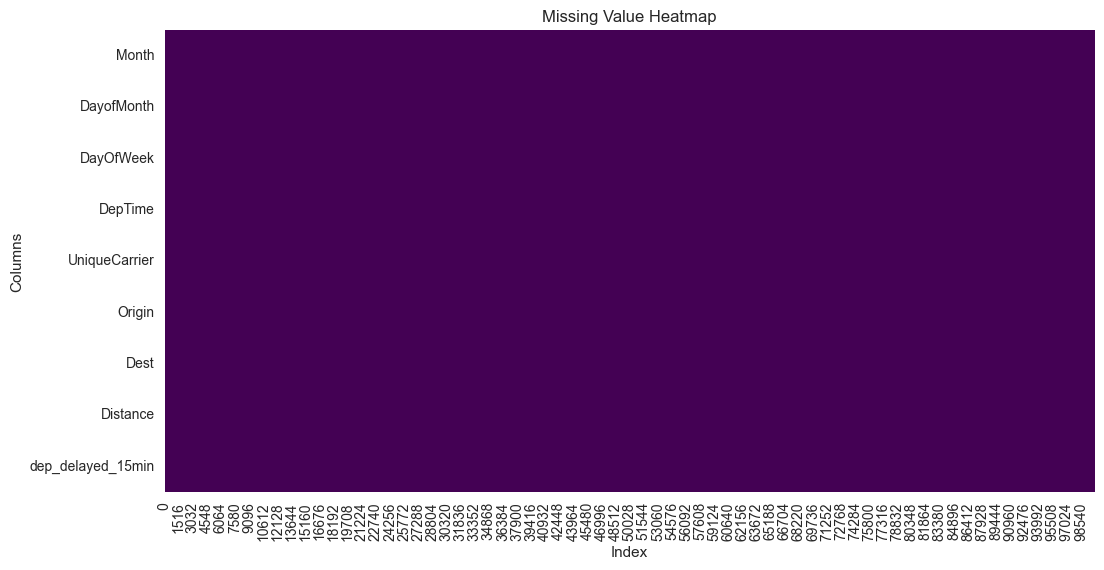

In [6]:
train_df_transpose = train_df.T

plt.figure(figsize=(12, 6))
sns.heatmap(train_df_transpose.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Value Heatmap")
plt.xlabel("Index")
plt.ylabel("Columns")
plt.show()

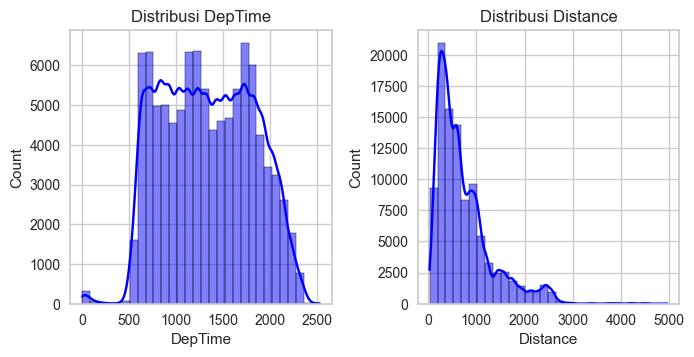

In [7]:
# Distribution for Numeric Features
num_features = train_df.select_dtypes(include=[np.number])
plt.figure(figsize=(14, 10))
for i, column in enumerate(num_features.columns, 1):
    plt.subplot(3, 4, i)
    sns.histplot(train_df[column], bins=30, kde=True, color='blue')
    plt.title(f'Distribusi {column}')
plt.tight_layout()
plt.show()

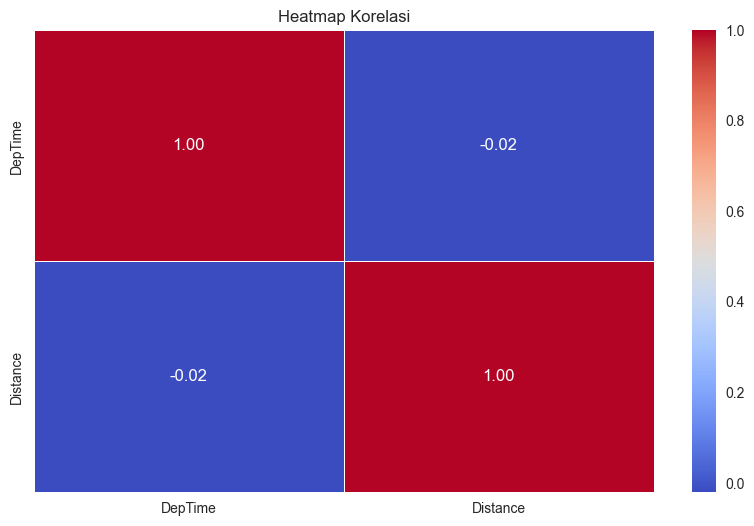

In [8]:
# Heatmap Correlation for numeric features
plt.figure(figsize=(10, 6))
correlation_matrix = num_features.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap Korelasi')
plt.show()

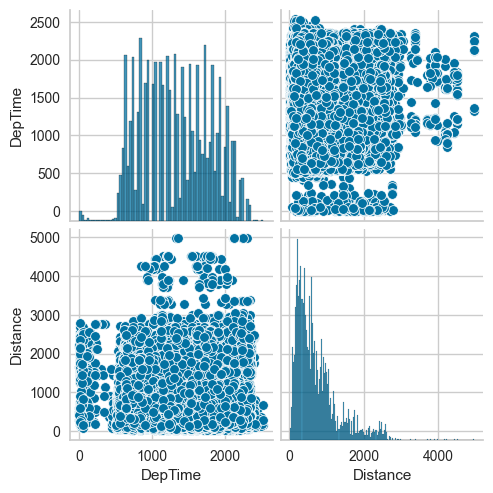

In [10]:
# Pair plot for numeric features
sns.pairplot(num_features)
plt.show()

# **Label Encoding**

In [9]:
# Encode target variabel 
train_df['dep_delayed_15min'] = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0})

In [11]:
test_df

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258
...,...,...,...,...,...,...,...,...
99995,c-6,c-5,c-2,852,WN,CRP,HOU,187
99996,c-11,c-24,c-6,1446,UA,ORD,LAS,1515
99997,c-1,c-30,c-2,1509,OO,ORD,SGF,438
99998,c-1,c-5,c-5,804,DL,LGA,ATL,761


In [15]:
label_encoder = LabelEncoder()

categorical_columns = ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest']

for column in categorical_columns:
    train_df[column] = label_encoder.fit_transform(train_df[column])
    
for column in categorical_columns:
    test_df[column] = label_encoder.fit_transform(test_df[column])

train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,10,13,6,1934,0,18,78,732,0
1,6,12,2,1548,18,217,171,834,0
2,11,11,4,1422,20,228,59,416,0
3,2,17,5,1015,15,78,175,872,0
4,1,28,5,1828,19,174,199,423,1


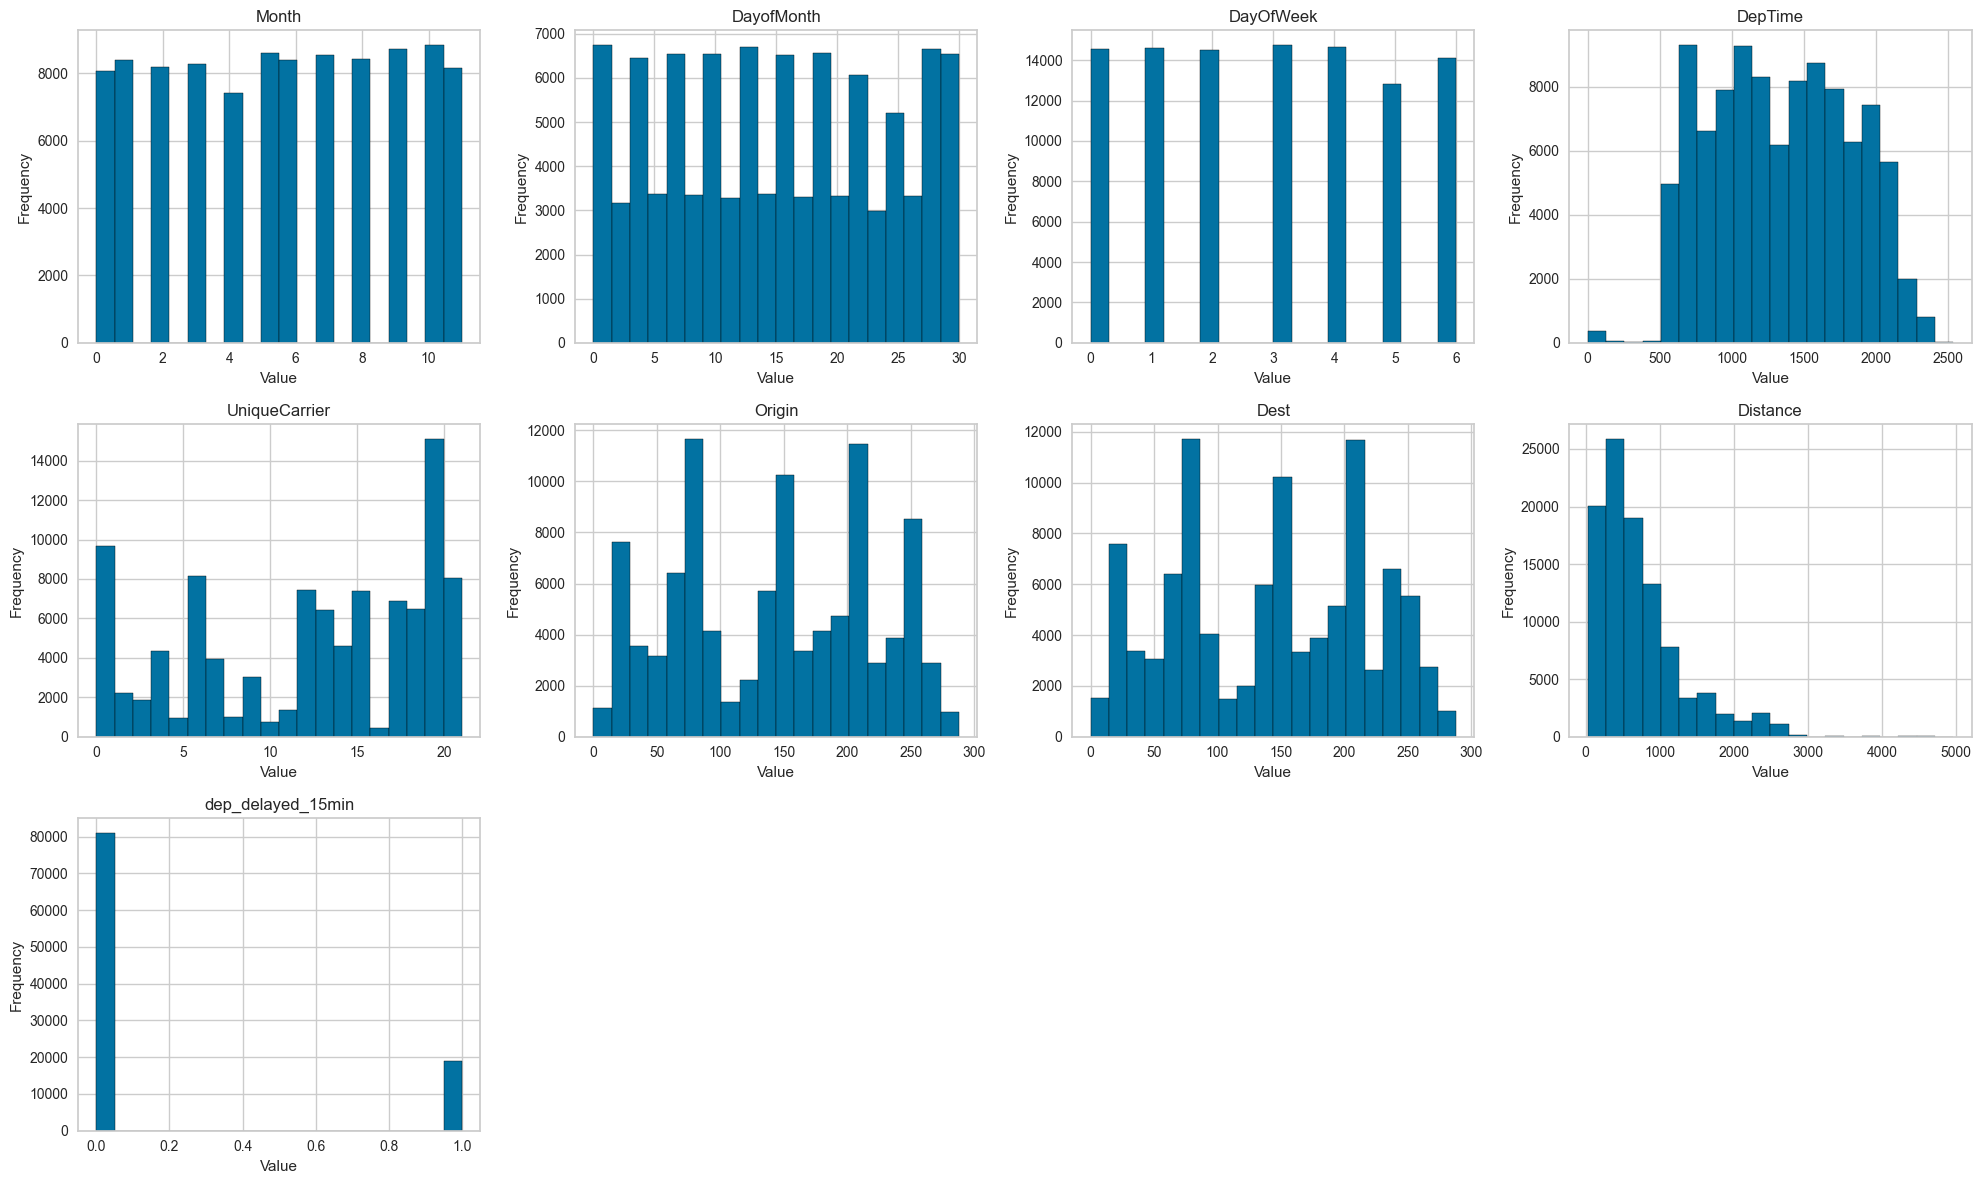

In [16]:
num_vars = train_df.shape[1]
n_cols = 4 
n_rows = -(-num_vars // n_cols) 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))

axes = axes.flatten()
 
for i, column in enumerate(train_df.columns):
    train_df[column].hist(ax=axes[i], bins=20, edgecolor='black')
    axes[i].set_title(column)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
 
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
 
plt.tight_layout()
plt.show()

# **Dataset Splitting**

In [18]:
X = train_df.drop(columns=['dep_delayed_15min'])
y = train_df['dep_delayed_15min']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((80000, 8), (20000, 8), (80000,), (20000,))

# **Training Data**

## **Train Without Hyperparameter Tunning**

In [20]:
preprocessor = ColumnTransformer([ 
    ('numeric', num_pipe(scaling="robust"), X_train.columns)
])

In [46]:
rf = Pipeline([
    ("prep", preprocessor),
    ("algo", RandomForestClassifier(n_estimators=100))
])

rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))
print(rf.score(X_val, y_val))

0.9999625
0.8252


In [24]:
knn = Pipeline([
    ("prep", preprocessor),
    ("algo", KNeighborsClassifier(n_neighbors=3))
])

knn.fit(X_train, y_train)
print(knn.score(X_train, y_train))
print(knn.score(X_val, y_val))

0.8638375
0.77165


In [26]:
xgb = Pipeline([
    ("prep", preprocessor),
    ("algo", XGBClassifier(objective='binary:logistic'))
])

xgb.fit(X_train, y_train)
print(xgb.score(X_train, y_train))
print(xgb.score(X_val, y_val))

0.843625
0.82535


In [31]:
sample_sub.head()

,id,dep_delayed_15min
0,0,0.081
1,1,0.387
2,2,0.069
3,3,0.177
4,4,0.732


In [40]:
y_pred_proba = knn.predict_proba(X_val)[:, 1]  # Ambil probabilitas untuk kelas positif
print(y_pred_proba)

[0. 0. 0. ... 0. 0. 0.]


In [47]:
print("KNN Evaluation : ")
y_val_pred_knn = knn.predict(X_val)
y_val_proba_knn = knn.predict_proba(X_val)[:, 1]
report_knn = classification_report(y_val, y_val_pred_knn)
print("Classification Report:")
print(report_knn)
# Confussion Matrix
cm_knn = confusion_matrix(y_val, y_val_pred_knn)
print("\nConfusion Matrix KNN :")
print(cm_knn)
print("KNN Evaluation :")
print(f"Precision (macro): {precision_score(y_val, y_val_pred_knn, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_pred_knn, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_pred_knn, average='macro', zero_division=0):.4f}")
# ROC-AUC
roc_auc_knn = roc_auc_score(y_val, y_val_proba_knn)
print(f"ROC-AUC KNN : {roc_auc_knn:.4f}")

print("\n" + "="*50 + "\n")

print("Random Forest Evaluation : ")
y_val_pred_rf = rf.predict(X_val)
y_val_proba_rf = rf.predict_proba(X_val)[:, 1]
report_rf = classification_report(y_val, y_val_pred_rf)
print("Classification Report:")
print(report_rf)

cm_rf = confusion_matrix(y_val, y_val_pred_rf)
print("\nConfusion Matrix Random Forest :")
print(cm_rf)
print("\nRandom Forest Evaluation :")
print(f"Precision (macro): {precision_score(y_val, y_val_pred_rf, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_pred_rf, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_pred_rf, average='macro', zero_division=0):.4f}")
# ROC-AUC
roc_auc_rf = roc_auc_score(y_val, y_val_proba_rf)
print(f"ROC-AUC Random Forest : {roc_auc_rf:.4f}")

print("\n" + "="*50 + "\n")

print("XGB Evaluation : ")
y_val_pred_xgb = xgb.predict(X_val)
y_val_proba_xgb = xgb.predict_proba(X_val)[:, 1]
report_xgb = classification_report(y_val, y_val_pred_xgb)
print("Classification Report:")
print(report_xgb)

cm_xgb = confusion_matrix(y_val, y_val_pred_xgb)
print("\nConfusion Matrix XGB :")
print(cm_xgb)
print("\nXGB Evaluation :")
print(f"Precision (macro): {precision_score(y_val, y_val_pred_xgb, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_pred_xgb, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_pred_xgb, average='macro', zero_division=0):.4f}")
# ROC-AUC
roc_auc_xgb = roc_auc_score(y_val, y_val_proba_xgb)
print(f"ROC-AUC: {roc_auc_xgb:.4f}")

KNN Evaluation : 
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87     16296
           1       0.31      0.20      0.24      3704

    accuracy                           0.77     20000
   macro avg       0.57      0.55      0.55     20000
weighted avg       0.74      0.77      0.75     20000


Confusion Matrix KNN :
[[14710  1586]
 [ 2981   723]]
KNN Evaluation :
Precision (macro): 0.5723
Recall (macro): 0.5489
F1-Score (macro): 0.5531
ROC-AUC KNN : 0.5957


Random Forest Evaluation : 
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.99      0.90     16296
           1       0.66      0.12      0.20      3704

    accuracy                           0.83     20000
   macro avg       0.74      0.55      0.55     20000
weighted avg       0.80      0.83      0.77     20000


Confusion Matrix Random Forest :
[[16073   223]
 [ 3273   431]]

Random Forest Evalu

In [48]:
sample_sub

,id,dep_delayed_15min
0,0,0.081
1,1,0.387
2,2,0.069
3,3,0.177
4,4,0.732
...,...,...
99995,99995,0.495
99996,99996,0.634
99997,99997,0.603
99998,99998,0.709


In [52]:
test_df

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,9,17,2,615,19,194,217,598
1,6,8,1,739,17,155,129,1235
2,3,11,6,651,11,121,208,577
3,5,17,6,1614,17,49,183,377
4,8,27,2,1505,15,209,270,258
...,...,...,...,...,...,...,...,...
99995,8,26,1,852,17,70,129,187
99996,2,16,5,1446,15,209,154,1515
99997,0,23,1,1509,14,209,254,438
99998,0,26,4,804,6,162,19,761


### **Make Submission without Hyperparameter Tunning**

In [50]:
sub_rf = rf.predict_proba(test_df)[:, 1]

In [56]:
submission_df_xgb_reg = pd.DataFrame({
    'id': ids,  
    'dep_delayed_15min': sub_rf
})
submission_df_xgb_reg.to_csv('submissionRF.csv', index=False)

In [57]:
sub_xgb = xgb.predict_proba(test_df)[:, 1]

In [58]:
submission_df_xgb = pd.DataFrame({
    'id': ids,  
    'dep_delayed_15min': sub_xgb
})
submission_df_xgb.to_csv('submissionXGB.csv', index=False)

## **Train with Hyperparameter Tunning**

In [59]:
preprocessor = ColumnTransformer([ 
    ('numeric', num_pipe(scaling="robust"), X_train.columns)
])

### Train with RandomForestClassifier Models

In [61]:
rsp.rf_params

{'algo__n_estimators': Integer(low=100, high=200),
 'algo__max_depth': Integer(low=20, high=80),
 'algo__max_features': Real(low=0.1, high=1, prior='uniform'),
 'algo__min_samples_leaf': Integer(low=1, high=20)}

In [62]:
# With Hyperparameter Randomized Search CV
pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", RandomForestClassifier())
])

model_rf_random = RandomizedSearchCV(pipeline, rsp.rf_params, n_iter = 50, cv=5, n_jobs=-1, verbose=1)
model_rf_random.fit(X_train, y_train)

print(model_rf_random.best_params_)

print(model_rf_random.score(X_train, y_train), model_rf_random.best_score_, model_rf_random.score(X_val, y_val))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'algo__max_depth': 79, 'algo__max_features': 0.5433034226617723, 'algo__min_samples_leaf': 4, 'algo__n_estimators': 188}
0.90155 0.819225 0.8269


In [63]:
# With Hyperparameter Bayes Search CV
pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", RandomForestClassifier())
])

model_rf_bsp = BayesSearchCV(pipeline, bsp.rf_params, n_iter = 50, cv=5, n_jobs=-1, verbose=1)
model_rf_bsp.fit(X_train, y_train)

print(model_rf_bsp.best_params_)
print(model_rf_bsp.score(X_train, y_train), model_rf_bsp.best_score_, model_rf_bsp.score(X_val, y_val))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [65]:
print("Random Forest Evaluation : \n")

print("Random Forest with Hyperparameter tunning Randomized Search CV : ")
best_model_rf_random = model_rf_random.best_estimator_
y_val_pred_rf_random = best_model_rf_random.predict(X_val)
y_val_proba_rf_random = best_model_rf_random.predict_proba(X_val)[:, 1]
report_rf_random = classification_report(y_val, y_val_pred_rf_random)
print("Classification Report:")
print(report_rf_random)

cm_rf_random = confusion_matrix(y_val, y_val_pred_rf_random)
print("\nConfusion Matrix Random Forest :")
print(cm_rf_random)
print("\nRandom Forest with Hyperparameter tunning Randomized Search CV Evaluation :")
print(f"Precision (macro): {precision_score(y_val, y_val_pred_rf_random, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_pred_rf_random, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_pred_rf_random, average='macro', zero_division=0):.4f}")
# ROC-AUC
roc_auc_rf_random = roc_auc_score(y_val, y_val_proba_rf_random)
print(f"ROC-AUC Random Forest : {roc_auc_rf_random:.4f}")

print("\n" + "="*50 + "\n")

print("Random Forest with Hyperparameter tunning Bayes Search CV : ")
best_model_rf_bayes     = model_rf_bsp.best_estimator_
y_val_pred_rf_bayes     = best_model_rf_bayes.predict(X_val)
y_val_proba_rf_bayes    = best_model_rf_bayes.predict_proba(X_val)[:, 1]
report_rf_bayes = classification_report(y_val, y_val_pred_rf_bayes)
print("Classification Report:")
print(report_rf_bayes)

cm_rf_bayes = confusion_matrix(y_val, y_val_pred_rf_bayes)
print("\nConfusion Matrix XGB :")
print(cm_rf_bayes)
print("\nRandom Forest with Hyperparameter tunning Bayes Search CV Evaluation Evaluation :")
print(f"Precision (macro): {precision_score(y_val, y_val_pred_rf_bayes, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_pred_rf_bayes, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_pred_rf_bayes, average='macro', zero_division=0):.4f}")
# ROC-AUC
roc_auc_rf_bayes = roc_auc_score(y_val, y_val_proba_rf_bayes)
print(f"ROC-AUC: {roc_auc_rf_bayes:.4f}")

Random Forest Evaluation : 

Random Forest with Hyperparameter tunning Randomized Search CV : 
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.99      0.90     16296
           1       0.70      0.11      0.20      3704

    accuracy                           0.83     20000
   macro avg       0.77      0.55      0.55     20000
weighted avg       0.81      0.83      0.77     20000


Confusion Matrix Random Forest :
[[16117   179]
 [ 3283   421]]

Random Forest with Hyperparameter tunning Randomized Search CV Evaluation :
Precision (macro): 0.7662
Recall (macro): 0.5513
F1-Score (macro): 0.5493
ROC-AUC Random Forest : 0.7369


Random Forest with Hyperparameter tunning Bayes Search CV : 
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.99      0.90     16296
           1       0.68      0.13      0.21      3704

    accuracy                           0.83     20000
   m

### **Make Submission with Hyperparameter Tunning Randomized and Bayes**

#### **SUBMISSION WITH RANDOM FOREST AND RANDOMIZED(HYPERPARAMETER TUNNING)**

In [66]:
sub_rf_random = best_model_rf_random.predict_proba(test_df)[:, 1]

In [67]:
submission_df_rf_random = pd.DataFrame({
    'id': ids,  
    'dep_delayed_15min': sub_rf_random
})
submission_df_rf_random.to_csv('submissionRF_Random.csv', index=False)

In [68]:
print(sub_rf_random)

[0.00673759 0.02623231 0.03424941 ... 0.26301355 0.10420435 0.10393582]


#### **SUBMISSION WITH RANDOM FOREST AND BAYES(HYPERPARAMETER TUNNING)**

In [69]:
sub_rf_bayes = best_model_rf_bayes.predict_proba(test_df)[:, 1]

In [71]:
submission_df_rf_bayes = pd.DataFrame({
    'id': ids,  
    'dep_delayed_15min': sub_rf_bayes
})
submission_df_rf_bayes.to_csv('submissionRF_Bayes.csv', index=False)

### Train with XGB Models

In [74]:
# With Hyperparameter Randomized Search CV
pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", XGBClassifier())
])

model_xgb_random = RandomizedSearchCV(pipeline, rsp.xgb_params, n_iter = 50, cv=5, n_jobs=-1, verbose=1)
model_xgb_random.fit(X_train, y_train)

print(model_xgb_random.best_params_)
print(model_xgb_random.score(X_train, y_train), model_xgb_random.best_score_, model_xgb_random.score(X_val, y_val))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'algo__colsample_bytree': 0.6447376875355925, 'algo__gamma': 1, 'algo__learning_rate': 0.10574974476980023, 'algo__max_depth': 5, 'algo__n_estimators': 154, 'algo__reg_alpha': 0.001011432599271508, 'algo__reg_lambda': 0.0078031630707918066, 'algo__subsample': 0.698456911617921}
0.82435 0.8178750000000001 0.82475


In [76]:
# With Hyperparameter Bayes Search CV
pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", XGBClassifier())
])

model_xgb_bayes = BayesSearchCV(pipeline, bsp.xgb_params, n_iter = 50, cv=5, n_jobs=-1, verbose=1)
model_xgb_bayes.fit(X_train, y_train)

print(model_xgb_bayes.best_params_)
print(model_xgb_bayes.score(X_train, y_train), model_xgb_bayes.best_score_, model_xgb_bayes.score(X_val, y_val))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [78]:
print("XGB Evaluation : \n")

print("XGB with Hyperparameter tunning Randomized Search CV : ")
best_model_xgb_random   = model_xgb_random.best_estimator_
y_val_pred_xgb_random   = best_model_xgb_random.predict(X_val)
y_val_proba_xgb_random  = best_model_xgb_random.predict_proba(X_val)[:, 1]
report_xgb_random = classification_report(y_val, y_val_pred_xgb_random)
print("Classification Report:")
print(report_xgb_random)

cm_xgb_random = confusion_matrix(y_val, y_val_pred_xgb_random)
print("\nConfusion Matrix XGB :")
print(cm_xgb_random)
print("\nXGB with Hyperparameter tunning Randomized Search CV Evaluation :")
print(f"Precision (macro): {precision_score(y_val, y_val_pred_xgb_random, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_pred_xgb_random, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_pred_xgb_random, average='macro', zero_division=0):.4f}")
# ROC-AUC
roc_auc_xgb_random = roc_auc_score(y_val, y_val_proba_xgb_random)
print(f"ROC-AUC Random Forest : {roc_auc_xgb_random:.4f}")

print("\n" + "="*50 + "\n")

print("XGB with Hyperparameter tunning Bayes Search CV : ")
best_model_xgb_bayes     = model_xgb_bayes.best_estimator_
y_val_pred_xgb_bayes     = best_model_xgb_bayes.predict(X_val)
y_val_proba_xgb_bayes    = best_model_xgb_bayes.predict_proba(X_val)[:, 1]
report_xgb_bayes         = classification_report(y_val, y_val_pred_xgb_bayes)
print("Classification Report:")
print(report_xgb_bayes)

cm_xgb_bayes = confusion_matrix(y_val, y_val_pred_xgb_bayes)
print("\nConfusion Matrix XGB :")
print(cm_xgb_bayes)
print("\nXGB with Hyperparameter tunning Bayes Search CV Evaluation Evaluation :")
print(f"Precision (macro): {precision_score(y_val, y_val_pred_xgb_bayes, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_pred_xgb_bayes, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_pred_xgb_bayes, average='macro', zero_division=0):.4f}")
# ROC-AUC
roc_auc_xgb_bayes = roc_auc_score(y_val, y_val_proba_xgb_bayes)
print(f"ROC-AUC: {roc_auc_xgb_bayes:.4f}")

XGB Evaluation : 

XGB with Hyperparameter tunning Randomized Search CV : 
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.99      0.90     16296
           1       0.67      0.10      0.18      3704

    accuracy                           0.82     20000
   macro avg       0.75      0.55      0.54     20000
weighted avg       0.80      0.82      0.77     20000


Confusion Matrix XGB :
[[16109   187]
 [ 3318   386]]

XGB with Hyperparameter tunning Randomized Search CV Evaluation :
Precision (macro): 0.7514
Recall (macro): 0.5464
F1-Score (macro): 0.5412
ROC-AUC Random Forest : 0.7348


XGB with Hyperparameter tunning Bayes Search CV : 
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     16296
           1       0.62      0.14      0.22      3704

    accuracy                           0.82     20000
   macro avg       0.73      0.56      0.56     20000


#### **Submission with XGB and Randomized(Hyperparameter Tunning)**

In [79]:
sub_xgb_random = best_model_xgb_random.predict_proba(test_df)[:, 1]

In [80]:
submission_df_xgb_random = pd.DataFrame({
    'id': ids,  
    'dep_delayed_15min': sub_xgb_random
})
submission_df_xgb_random.to_csv('submissionXGB_Random.csv', index=False)

#### **Submission with XGB and Bayesian(Hyperparameter Tunning)**

In [81]:
sub_xgb_bayes = best_model_xgb_bayes.predict_proba(test_df)[:, 1]

In [83]:
submission_df_xgb_bayes = pd.DataFrame({
    'id': ids,  
    'dep_delayed_15min': sub_xgb_bayes
})
submission_df_xgb_bayes.to_csv('submissionXGB_Bayes.csv', index=False)

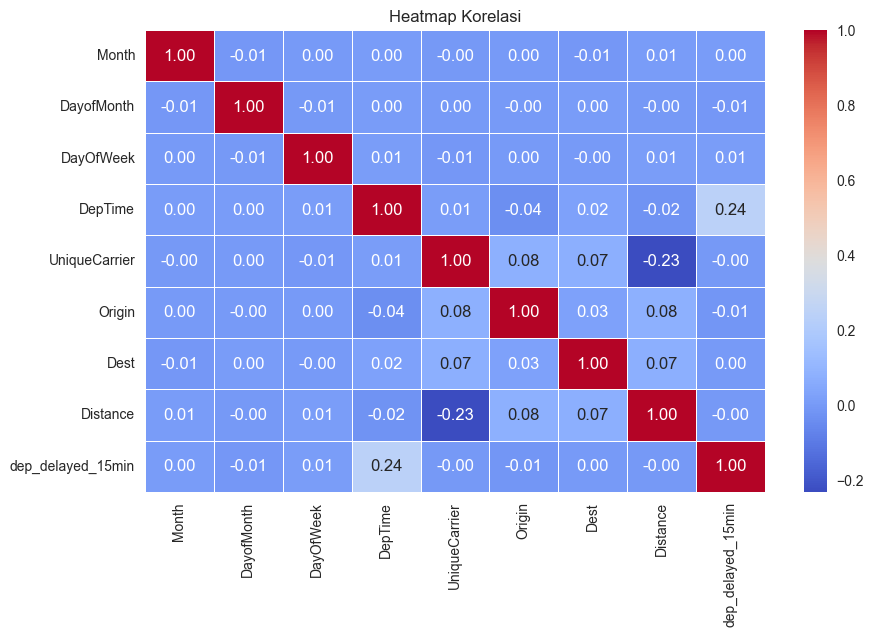

In [85]:
num_features = train_df.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 6))
correlation_matrix = num_features.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap Korelasi')
plt.show()

In [86]:
train_df

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,10,13,6,1934,0,18,78,732,0
1,6,12,2,1548,18,217,171,834,0
2,11,11,4,1422,20,228,59,416,0
3,2,17,5,1015,15,78,175,872,0
4,1,28,5,1828,19,174,199,423,1
...,...,...,...,...,...,...,...,...,...
99995,7,25,2,1618,15,246,224,199,0
99996,0,9,2,804,4,92,72,884,0
99997,0,16,1,1901,13,85,131,1076,0
99998,6,19,3,1515,12,79,107,140,0


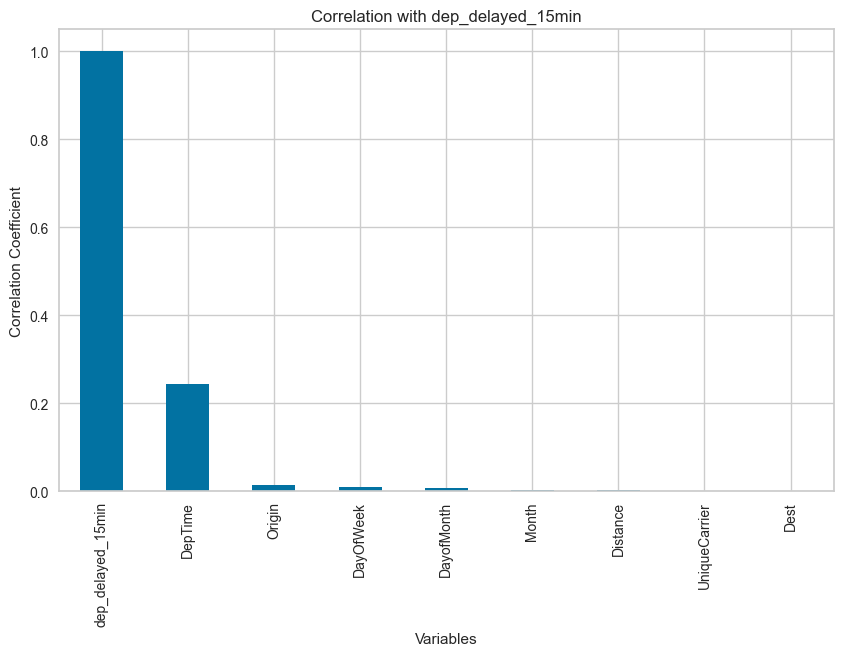

In [88]:
target_corr = train_df.corr()['dep_delayed_15min']

target_corr_sorted = target_corr.abs().sort_values(ascending=False)
 
plt.figure(figsize=(10, 6))
target_corr_sorted.plot(kind='bar')
plt.title(f'Correlation with dep_delayed_15min')
plt.xlabel('Variables')
plt.ylabel('Correlation Coefficient')
plt.show()